**Random Forest**

É um “upgrade” da árvore de decisão onde várias árvores contendo uma parte do total das features são utilizadas para a classificação ao invés da árvore única da Decision Tree (que trabalha com todas as features).


In [55]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# carregando a base de dados de censo
base = pd.read_csv('../../res/census.csv')



In [56]:
# separando os dados de previsao e classificacao
previsores = base.iloc[:, 0:14].values
classificadores = base.iloc[:, 14].values

#gerando uma copia dos dados originais para fazer mais testes abaixo
previsores_escalonados=previsores.copy()

#transformando dados categorios da base em dados discretos

labelencoder_prev = LabelEncoder()
previsores[:, 1] = labelencoder_prev.fit_transform(previsores[:, 1])
previsores[:, 3] = labelencoder_prev.fit_transform(previsores[:, 3])
previsores[:, 5] = labelencoder_prev.fit_transform(previsores[:, 5])
previsores[:, 6] = labelencoder_prev.fit_transform(previsores[:, 6])
previsores[:, 7] = labelencoder_prev.fit_transform(previsores[:, 7])
previsores[:, 8] = labelencoder_prev.fit_transform(previsores[:, 8])
previsores[:, 9] = labelencoder_prev.fit_transform(previsores[:, 9])
previsores[:, 13] = labelencoder_prev.fit_transform(previsores[:, 13])



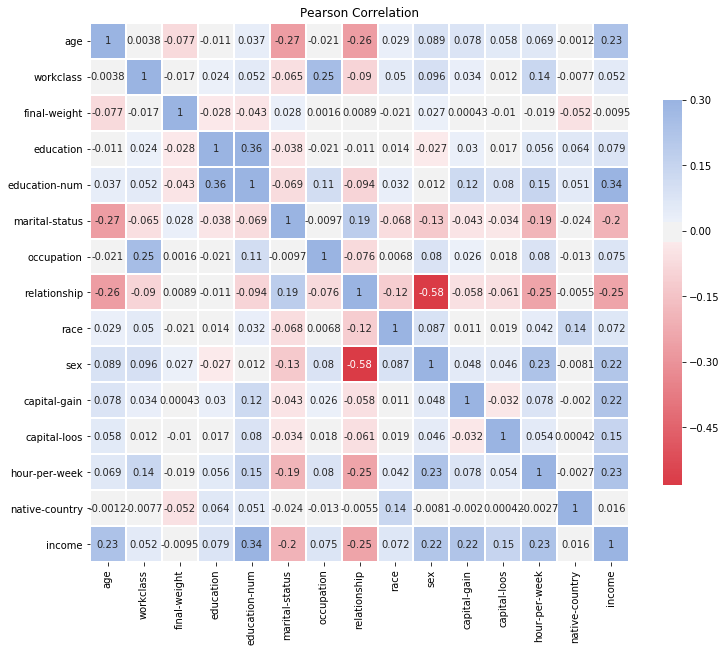

In [57]:
# Criando uma tabela de correlacao de pearson para entender a correlacao entre as variaveis

#gerando uma copia dos dados com a label encodada
alldata= previsores.copy()
alldata=np.append(alldata,classificadores.reshape(-1,1),axis=1)
alldata[:,14] = labelencoder_prev.fit_transform(alldata[:,14])

alldata=alldata.astype(float)
alldata =pd.DataFrame(alldata,columns=base.columns)


#gerando a matriz de correlacao a partir destes dados
corr = alldata.corr()
ds=len(alldata.columns)

cmap = sns.diverging_palette(10, 255, as_cmap=True)

plt.figure(figsize=(20, 11))
plt.subplot(1, 2, 1)
plt.title("Pearson Correlation")
ax = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5})
ax.set_ylim(ds, 0)

plt.tight_layout()
plt.show()


In [58]:
#fazendo o one hot encoder para a copia da base (para os valores discretos)
#preprocess = make_column_transformer(( OneHotEncoder(categories='auto'), [1,3,5,6,7,8,9,13] ),remainder="passthrough") 
#previsores_escalonados = preprocess.fit_transform(previsores_escalonados).toarray()

#removendo colunas com correlacao alta para verificar se a parformance melhora
previsores_less_cols=previsores.copy()

previsores_less_cols= np.delete(previsores,2,axis=1) #final-weight
previsores_less_cols= np.delete(previsores_less_cols,12,axis=1) #native-country



#previsores_less_cols= np.delete(previsores_less_cols,1,axis=1) #workclass




#separando os valores de teste e treinamento  para os previsores escalonados e nao escalonados
previsores_treinamento, previsores_teste, classificadores_treinamento1, classificadores_teste1 = train_test_split(previsores, classificadores, test_size=0.15, random_state=0)
previsores_treinamentolc, previsores_testelc, classificadores_treinamentolc, classificadores_testelc = train_test_split(previsores_less_cols, classificadores, test_size=0.15, random_state=0)



In [59]:
classificador = RandomForestClassifier(n_estimators=100,min_samples_split=22, criterion='entropy',random_state=0,n_jobs=8) # n_estimators = numero de arvores , n_jobs numero de cores utilizado para paralelizar o processo

classificador.fit(previsores_treinamento, classificadores_treinamento1)
previsoes = classificador.predict(previsores_teste)

#verificando a importancia de cada feature para o algoritimo
print("\nImportancia das features com todos os dados")
#print(np.round(classificador.feature_importances_*100, 2))
print(np.sum(classificador.feature_importances_))

# rodando previsoes com o dados de teste (copia)
classificador.fit(previsores_treinamentolc, classificadores_treinamentolc)
# fazendo o fit com os dados de copia
previsoeslc = classificador.predict(previsores_testelc)
print("\nImportancia das features com as colunas a menos")
#print(np.round(classificador.feature_importances_*100, 2))
print(np.sum(classificador.feature_importances_))


Importancia das features com todos os dados
0.9999999999999999

Importancia das features com as colunas a menos
1.0000000000000002


In [60]:
#testes dessa instancia algoritimo

# o dado de precisao per se nao quer dizer muita coisa e preciso verificar outras metricas
#precisao_escalonados = accuracy_score(classificadores_teste, previsoes_dados_escalonados)
precisao = accuracy_score(classificadores_teste1, previsoes)
precisaolc = accuracy_score(classificadores_testelc, previsoeslc)

# uma dessas metricas eh a matriz de confusao ... ela e capaz de mostrar o desempenho do algoritimo para cada classe 
matrizlc = confusion_matrix(classificadores_testelc, previsoeslc)
matriz = confusion_matrix(classificadores_teste1, previsoes)

#o scikit tambem possui uma classe utilitaria que prove um report mais detalhado...
reportlc = classification_report(classificadores_testelc, previsoeslc)
report = classification_report(classificadores_teste1, previsoes)

print("Precisão  :\n")
print(precisao)
print("\n")
print(precisaolc)
print("\nMatriz de confusão :\n")
print(matriz)
print("\n")
print(matrizlc)
print("\nReport :\n")
print (report)
print("\n")
print (reportlc)


Precisão  :

0.8573183213920164


0.8605936540429887

Matriz de confusão :

[[3449  244]
 [ 453  739]]


[[3444  249]
 [ 432  760]]

Report :

              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      3693
        >50K       0.75      0.62      0.68      1192

    accuracy                           0.86      4885
   macro avg       0.82      0.78      0.79      4885
weighted avg       0.85      0.86      0.85      4885



              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      3693
        >50K       0.75      0.64      0.69      1192

    accuracy                           0.86      4885
   macro avg       0.82      0.79      0.80      4885
weighted avg       0.86      0.86      0.86      4885



<br>**TODO :Verificar a base de treinamento para melhorar a distribuicao das classes e verificar se ha alguma melhora**